# Milestone 2 - First Model

In [59]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
from scripts import *
from first_scripts import *
from tqdm import tqdm
import pickle as pkl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix


### I. Data Prepration

In [21]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader(data_path)


In [22]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [23]:
len(images)

2351

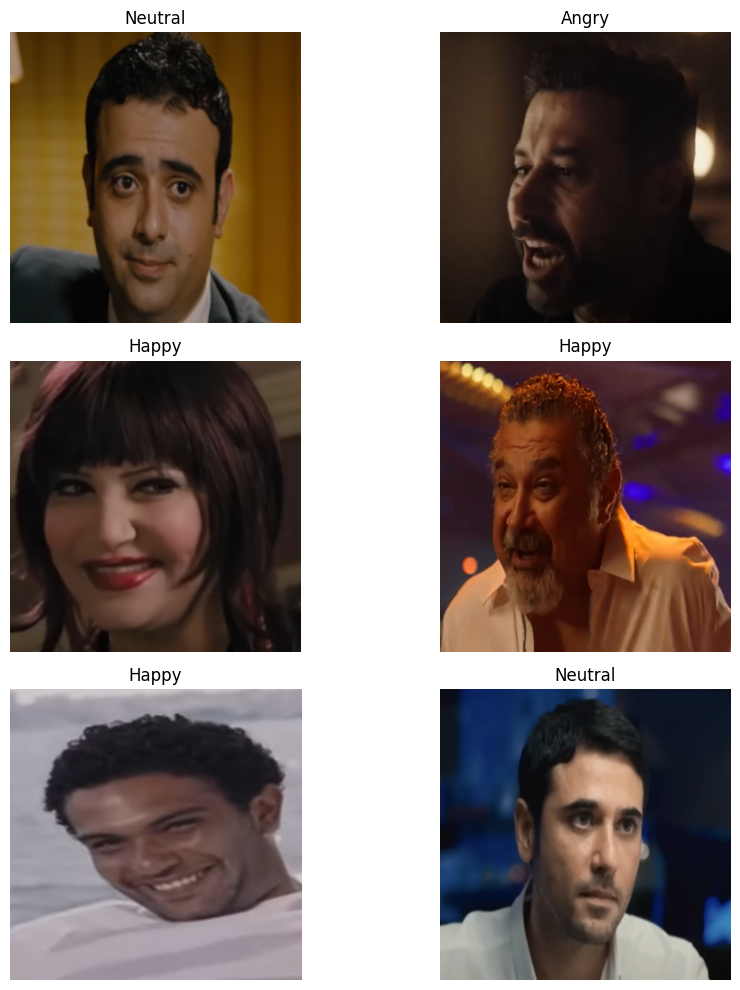

In [24]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    img = read_img(images[idx])
    ax.imshow(img)
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [25]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645,), (1645,), (470,), (470,), (236,), (236,))

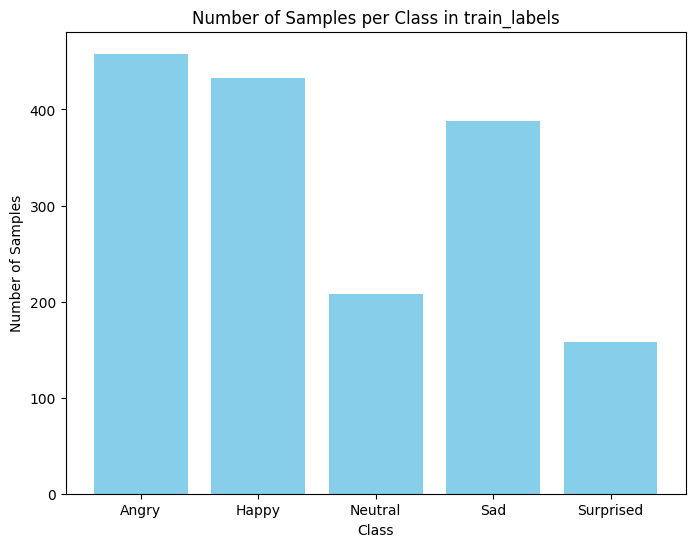

In [26]:
draw_barchart_labels(train_labels, label_to_index)

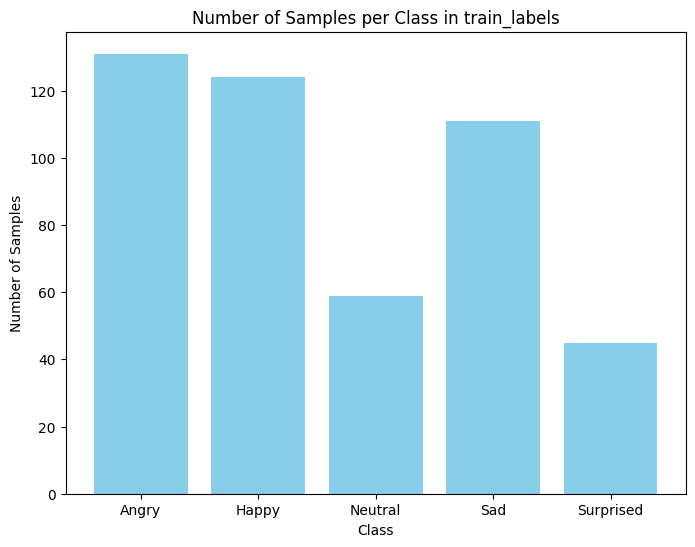

In [27]:
draw_barchart_labels(val_labels, label_to_index)

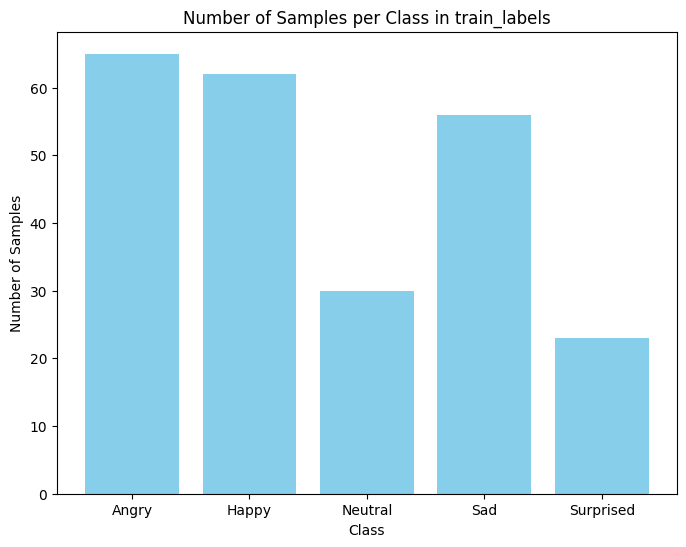

In [28]:
draw_barchart_labels(test_labels, label_to_index)

### II.First Model

In [29]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

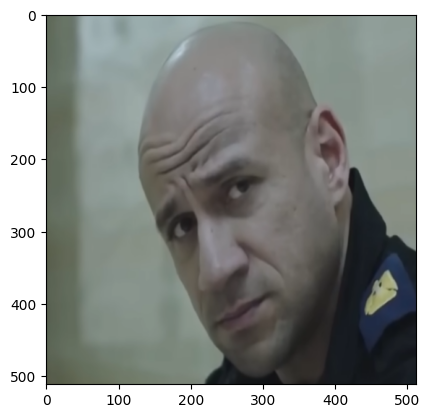

In [30]:
# Get example
path = train_data[0]
img = read_img(path)
# View img
plt.imshow(img) 

In [31]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(img)
output.shape

(510, 510, 4)

In [32]:
random_arr = np.random.rand(3, 3, 3)
random_arr_2 = np.random.rand(3, 3, 3)
np.dot(random_arr.flatten(), random_arr_2.flatten())

6.4263519311652155

In [33]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)

output = conv_layer.forward(img)
output.shape

(510, 510, 5)

In [34]:
# Check if fast conv and normal conv are the same
conv_layer_fast = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=True)
output_fast = conv_layer_fast.forward(img)
conv_layer_normal = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)
output_normal = conv_layer_normal.forward(img)
print(f"Are the outputs the same? {np.equal(output_fast, output_normal).all()}")

Are the outputs the same? True


In [35]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(img)
output.shape

(256, 256, 3)

#### Use Predefined Filters

In [36]:
# Trying to apply the first model on the image
first_model = FirstModel()
print("finish loading data...")
example_data = np.array(img)
output = first_model.forward(example_data)
output.shape

finish loading data...


(1, 128)

In [37]:

# Running the model on all of the data
at_once = 20
output = []
for i in tqdm(range(0, len(train_data), at_once), desc="Processing images"):
    # Load at_once images
    batch_end = min(at_once, len(train_data) - i)
    data = [read_img(train_data[i + j]) for j in range(batch_end)]
    
    for j in range(len(data)):
        input_img = np.array(data[j])
        output.append(first_model.forward(input_img))

# Convert to numpy array
output = np.array(output)
output.shape

Processing images: 100%|██████████| 83/83 [08:22<00:00,  6.06s/it]


(1645, 1, 128)

In [38]:
# Fixing the output shape by removing the middle dimension
if len(output.shape) == 3:
    output = np.squeeze(output, axis=1)
output.shape

(1645, 128)

In [39]:
features_path = './features/first_model_features_predefined_weights.pkl'
with open(features_path, 'wb') as f:
    pkl.dump(output, f)

In [50]:
# Fit kmeans 
kmeans = KMeans(n_clusters=5, random_state=0, init='k-means++', max_iter=1000)
kmeans.fit(output)
labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_
# Get the silhouette score
silhouette_avg = silhouette_score(output, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.11599631650631341


c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The silhouette score is +ve but very small which indicates that the clusters are barely distinct, with many points likely close to the boundaries of multiple clusters or misassigned. The clustering may not be meaningful or effective.

In [ ]:
# count number of labels in each cluster
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4]), array([242, 525, 333, 312, 233], dtype=int64))

In [68]:
def map_clusters_to_labels(cluster_ids: np.ndarray, true_labels: np.ndarray) -> Tuple[np.ndarray, Dict[int, int]]:
    """
    Maps cluster IDs to true labels based on the most common true label in each cluster.

    Args:
        cluster_ids (np.ndarray): Array of cluster IDs assigned by KMeans.
        true_labels (np.ndarray): Array of true labels corresponding to the data points.
    
    Returns:
        Tuple[np.ndarray, Dict[int, int]]: A tuple containing:
            - An array of mapped labels for each cluster ID.
            - A dictionary mapping each cluster ID to its most common true label.
    """
    mapped_labels = np.zeros_like(cluster_ids)
    clusters_to_labels = {}
    for cl in np.unique(cluster_ids):
        mask = (cluster_ids == cl)
        mapped_labels[mask] = mode(true_labels[mask]).mode[0]
        print(f"Cluster {cl}: True label {mapped_labels[mask][0]}")
        clusters_to_labels[cl] = mapped_labels[mask][0]
    return mapped_labels, clusters_to_labels
    
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)

Cluster 0: True label 1
Cluster 1: True label 3
Cluster 2: True label 0
Cluster 3: True label 0
Cluster 4: True label 1


C:\Users\001\AppData\Local\Temp\ipykernel_32824\2832899773.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mapped_labels[mask] = mode(true_labels[mask]).mode[0]


In [69]:
def plot_cm(cm: np.ndarray):
    """
    Plot the confusion matrix using matplotlib.
    Args:
        cm (np.ndarray): Confusion matrix to plot.
    """
    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()
    # Annotate each cell with the count
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')

Clustering accuracy for training: 30.64%


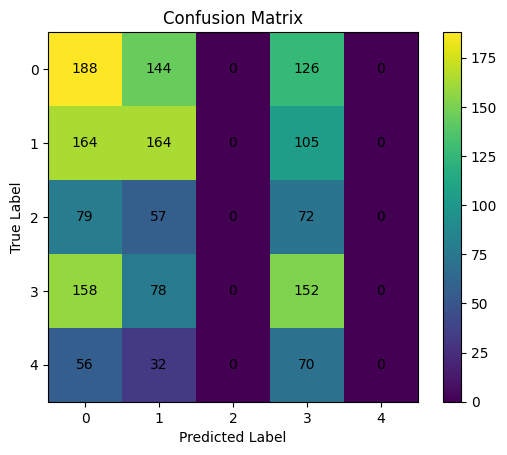

In [70]:
acc = accuracy_score(train_labels, y_pred)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, y_pred)
plot_cm(cm)

class 2 and 4 are a minority in the dataset so no clusters are labeled with them because we mapped the clusters to true labels by majority voting

In [83]:
# Method to apply pca then kmeans to be able to visualize the data
def plot_feature_scatter(
    features: np.ndarray,
    clusters:int=5,
    n_components: int = 2,
):
    """
    Plot PCA-reduced features in 2D or 3D based on n_components.

    Args:
        features (np.ndarray): Feature matrix of shape (N, D).
        clusters (int): Number of clusters for KMeans.
        n_components (int): 2 for 2D plot, 3 for 3D plot.
    """
    proj = PCA(n_components=n_components).fit_transform(features)

    # Normalize the data
    scaler = MinMaxScaler()
    proj = scaler.fit_transform(proj)    

    # Fit KMeans on the PCA-reduced data
    kmeans = KMeans(n_clusters=clusters, random_state=0, init='k-means++', max_iter=1000)
    kmeans.fit(proj)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_


    figsize = (20,20)

    fig = plt.figure(figsize=figsize)

    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', s=20)
        handles, legend_labels = scatter.legend_elements()
        ax.legend(handles, legend_labels, title="Cluster")
        
        centers = ax.scatter(
            cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            c='black', 
            s=200, 
            alpha=0.7, 
            marker='X',
            edgecolors='white',
            linewidths=2,
            label='Cluster Centers'
        )
        
        handles.append(centers)
        legend_labels = list(legend_labels) + ['Cluster Centers']
        ax.legend(handles, legend_labels, title="Cluster", loc='best')
        
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_title("2D PCA Projection of Cluster Assignments")

    elif n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], c=labels, cmap='tab10', s=20)
        handles, legend_labels = scatter.legend_elements()
        
        # Add cluster centers
        centers = ax.scatter(
            cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            cluster_centers[:, 2], 
            c='black', 
            s=200, 
            alpha=0.7, 
            marker='X',
            edgecolors='white',
            linewidths=2,
            label='Cluster Centers'
        )
        
        handles.append(centers)
        legend_labels = list(legend_labels) + ['Cluster Centers']
        ax.legend(handles, legend_labels, title="Cluster", loc='best')
        
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("3D PCA Projection of Cluster Assignments")

    else:
        raise ValueError("n_components must be 2 or 3 for plotting")

    plt.show()

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


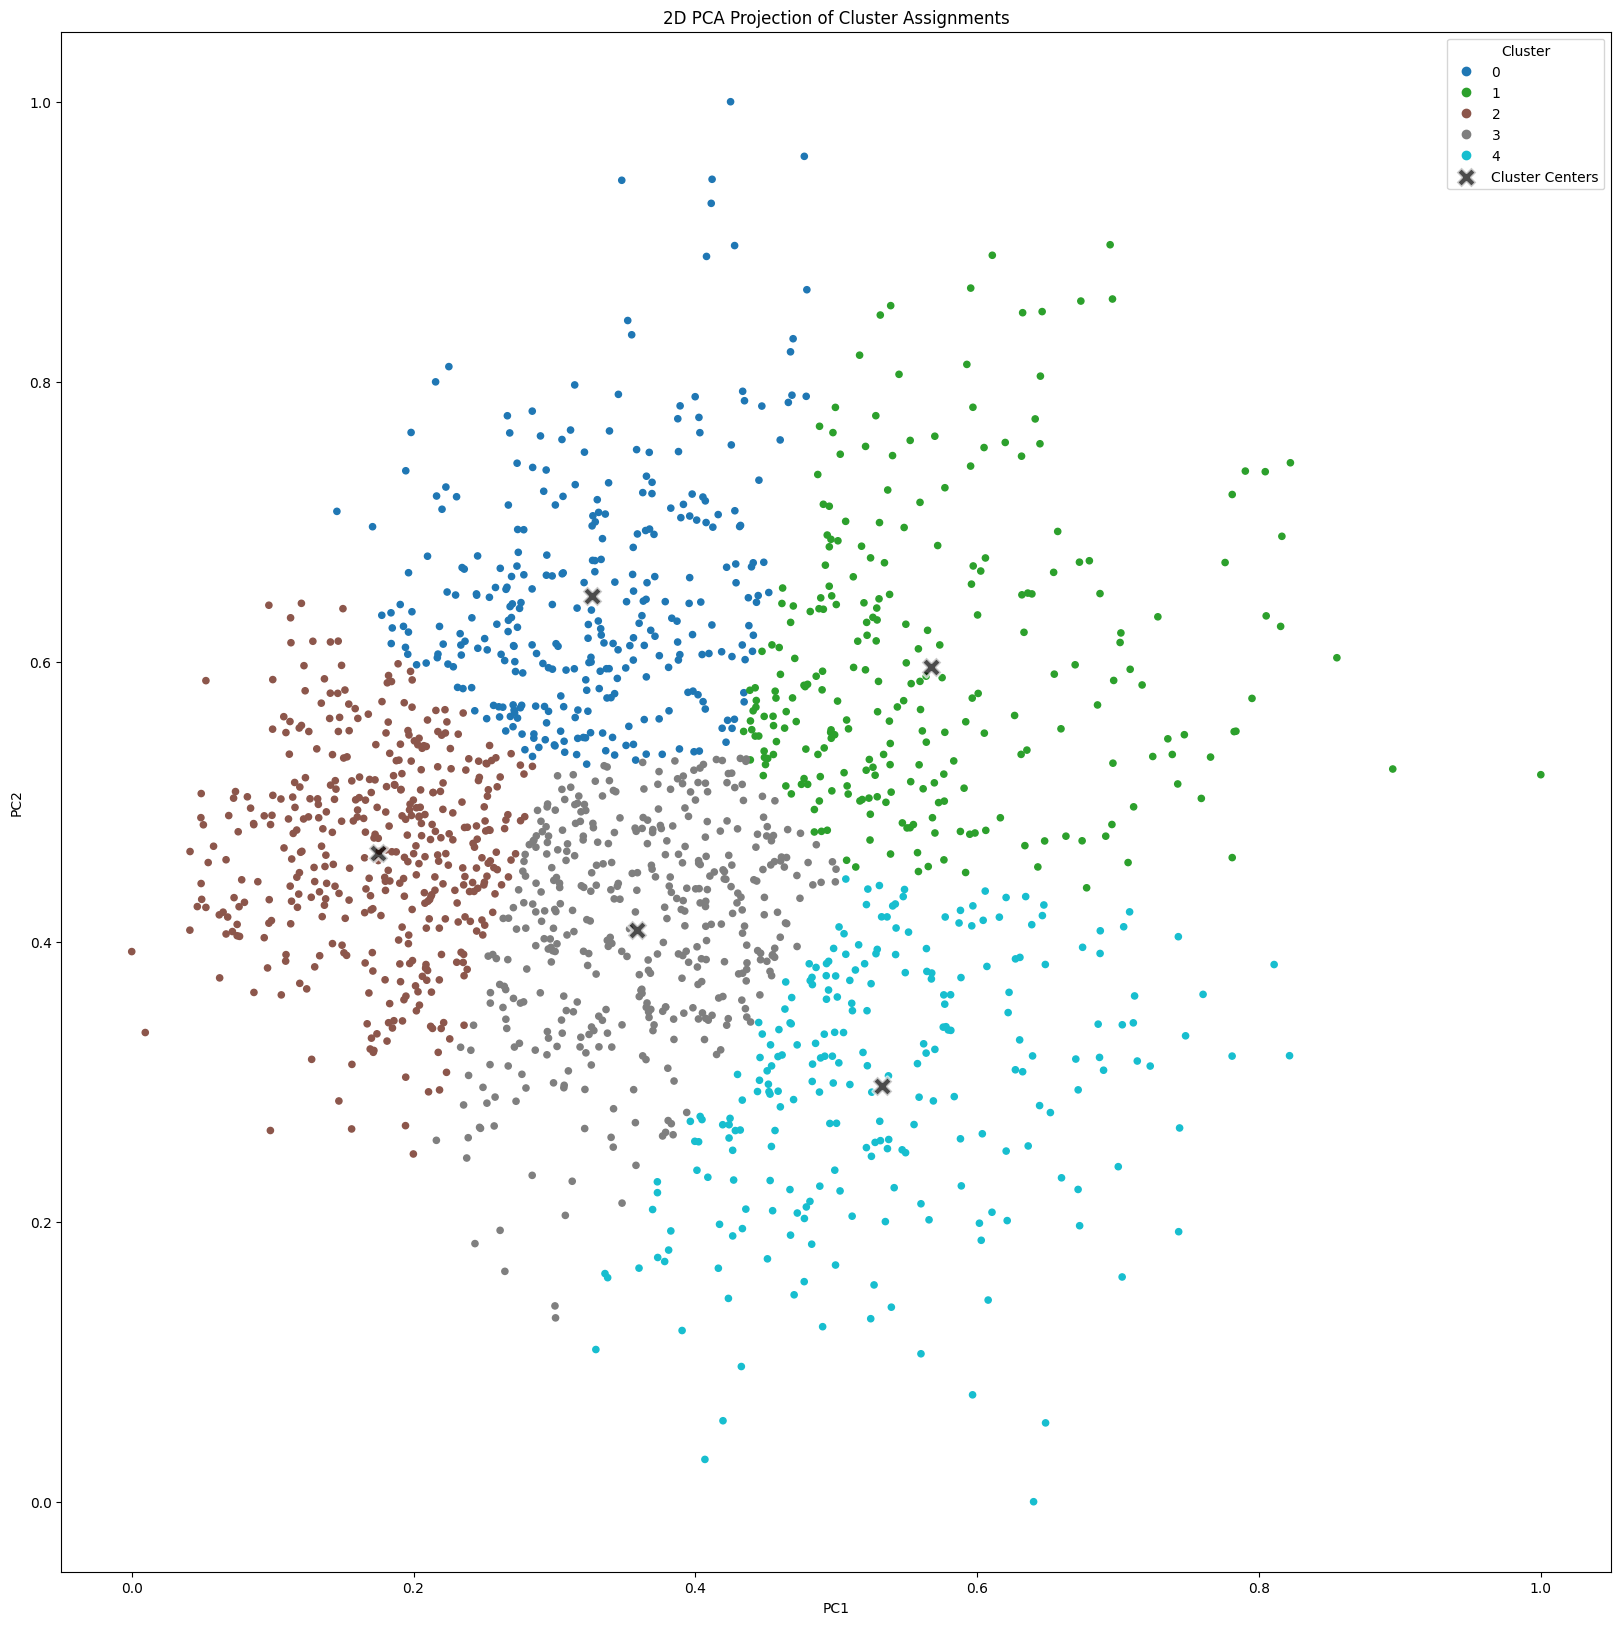

In [42]:
plot_feature_scatter(output, clusters=5, n_components=2)

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


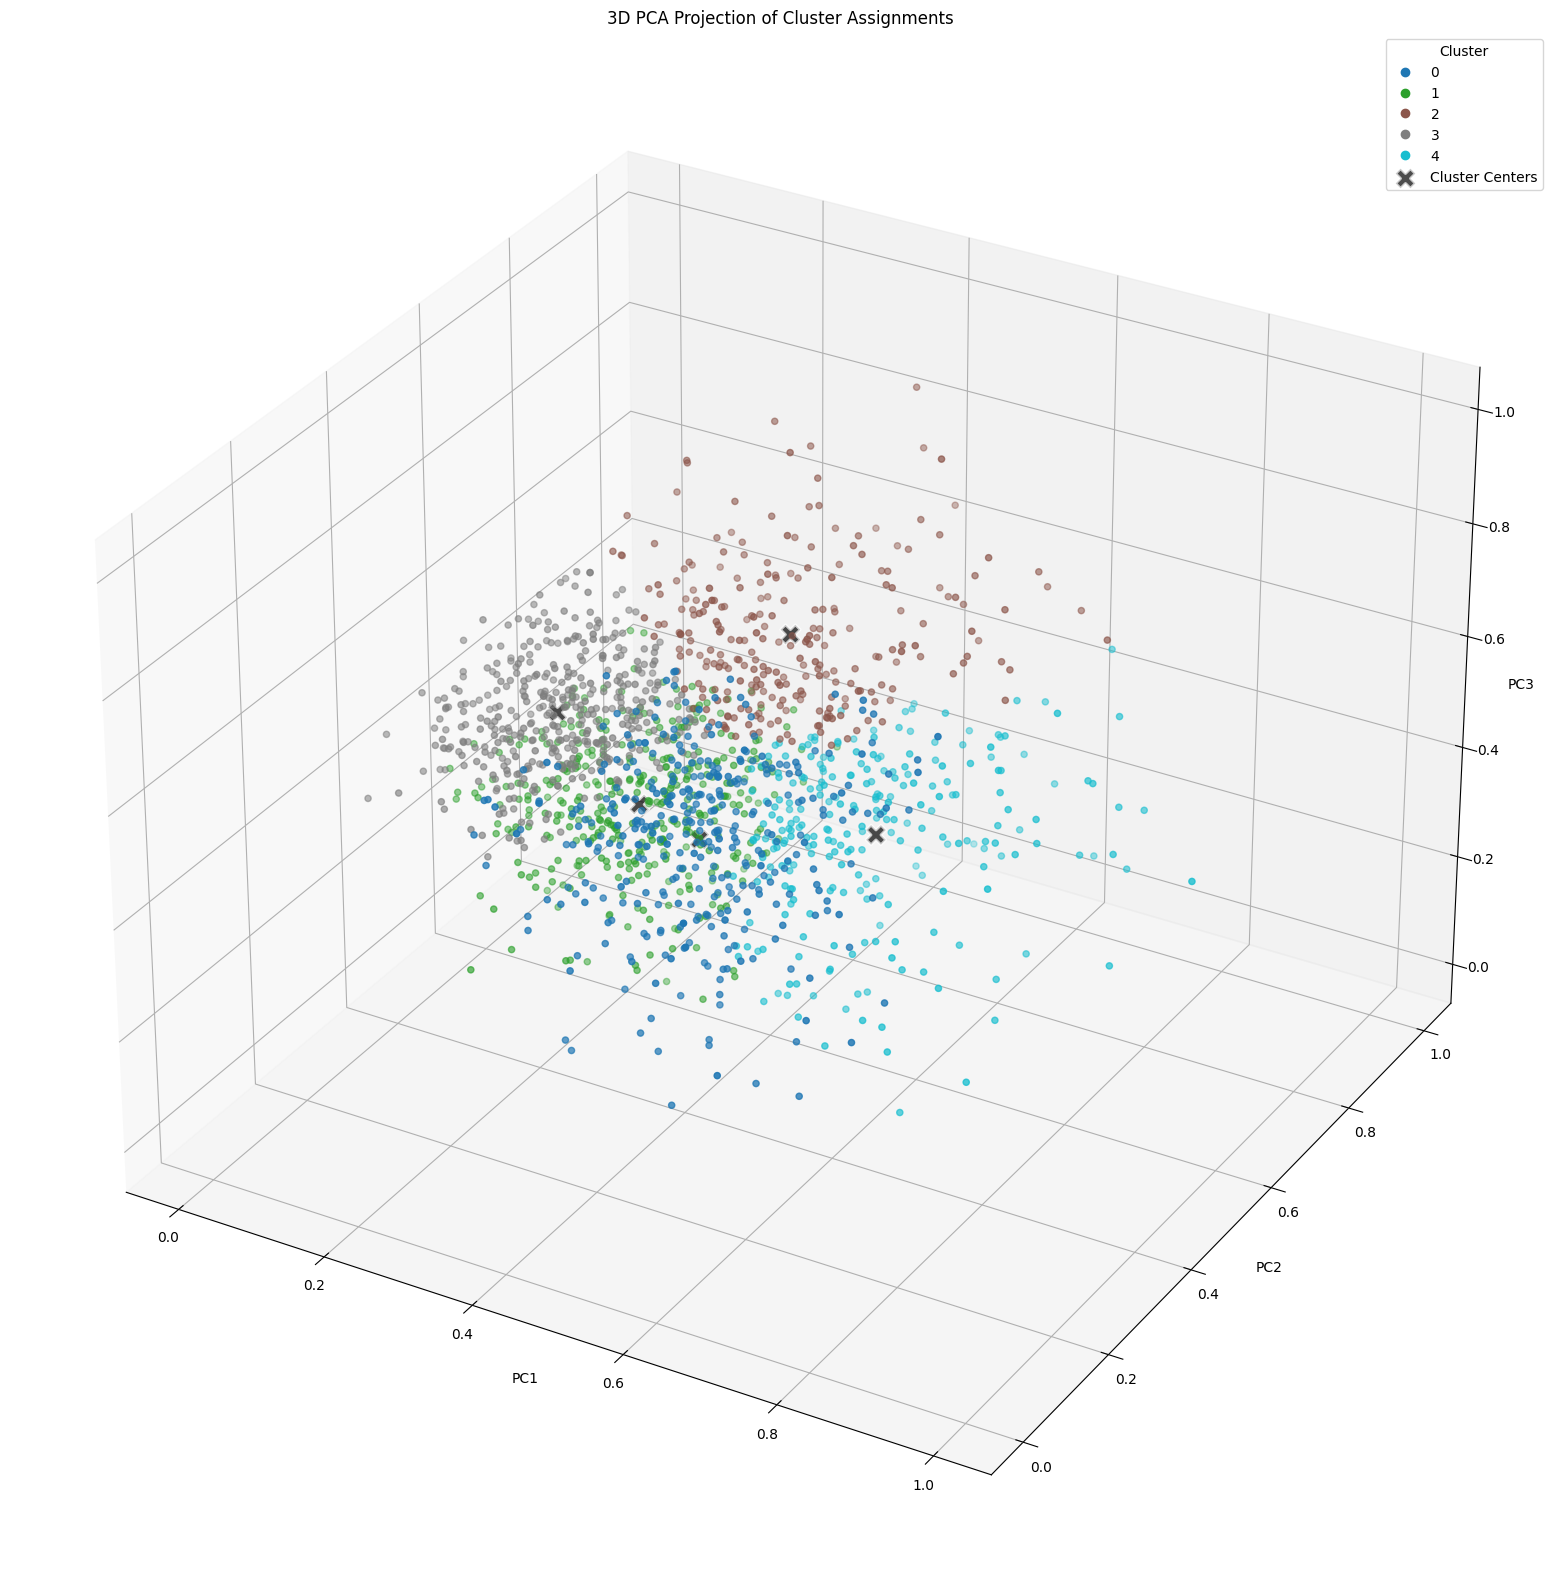

In [43]:
# Plot a 3D scatter plot
plot_feature_scatter(output, clusters=5, n_components=3)

#### Use Random Filters

In [73]:
# Trying to apply the first model on the image
first_model = FirstModel(use_predefined_filters=False)
print("finish loading data...")
example_data = np.array(img)
output = first_model.forward(example_data)
output.shape

finish loading data...


(1, 128)

In [74]:

# Running the model on all of the data
at_once = 20
output = []
for i in tqdm(range(0, len(train_data), at_once), desc="Processing images"):
    # Load at_once images
    batch_end = min(at_once, len(train_data) - i)
    data = [read_img(train_data[i + j]) for j in range(batch_end)]
    
    for j in range(len(data)):
        input_img = np.array(data[j])
        output.append(first_model.forward(input_img))

# Convert to numpy array
output = np.array(output)
output.shape

Processing images: 100%|██████████| 83/83 [08:15<00:00,  5.97s/it]


(1645, 1, 128)

In [75]:
# Fixing the output shape by removing the middle dimension
if len(output.shape) == 3:
    output = np.squeeze(output, axis=1)
output.shape

(1645, 128)

In [76]:
features_path = './features/first_model_features_random_weights.pkl'
with open(features_path, 'wb') as f:
    pkl.dump(output, f)

In [77]:
# Fit kmeans 
kmeans = KMeans(n_clusters=5, random_state=0, init='k-means++', max_iter=1000)
kmeans.fit(output)
labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_
# Get the silhouette score
silhouette_avg = silhouette_score(output, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.09932950674780458


The silhouette score is +ve but very small which indicates that the clusters are barely distinct, with many points likely close to the boundaries of multiple clusters or misassigned. The clustering may not be meaningful or effective.

In [78]:
# count number of labels in each cluster
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4]), array([307, 419, 253, 313, 353], dtype=int64))

In [79]:
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)

Cluster 0: True label 1
Cluster 1: True label 0
Cluster 2: True label 1
Cluster 3: True label 1
Cluster 4: True label 0


C:\Users\001\AppData\Local\Temp\ipykernel_32824\2832899773.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mapped_labels[mask] = mode(true_labels[mask]).mode[0]


Clustering accuracy for training: 30.03%


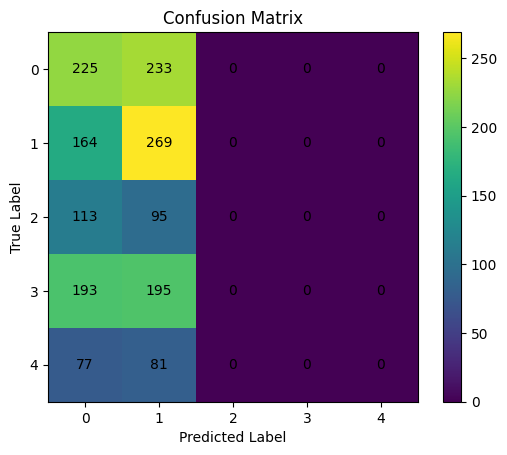

In [80]:
acc = accuracy_score(train_labels, y_pred)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, y_pred)
plot_cm(cm)

class 2, 3 and 4 are a minority in the dataset so no clusters are labeled with them because we mapped the clusters to true labels by majority voting. Also, the filters are random weights and not trained so the outputs are not good.

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


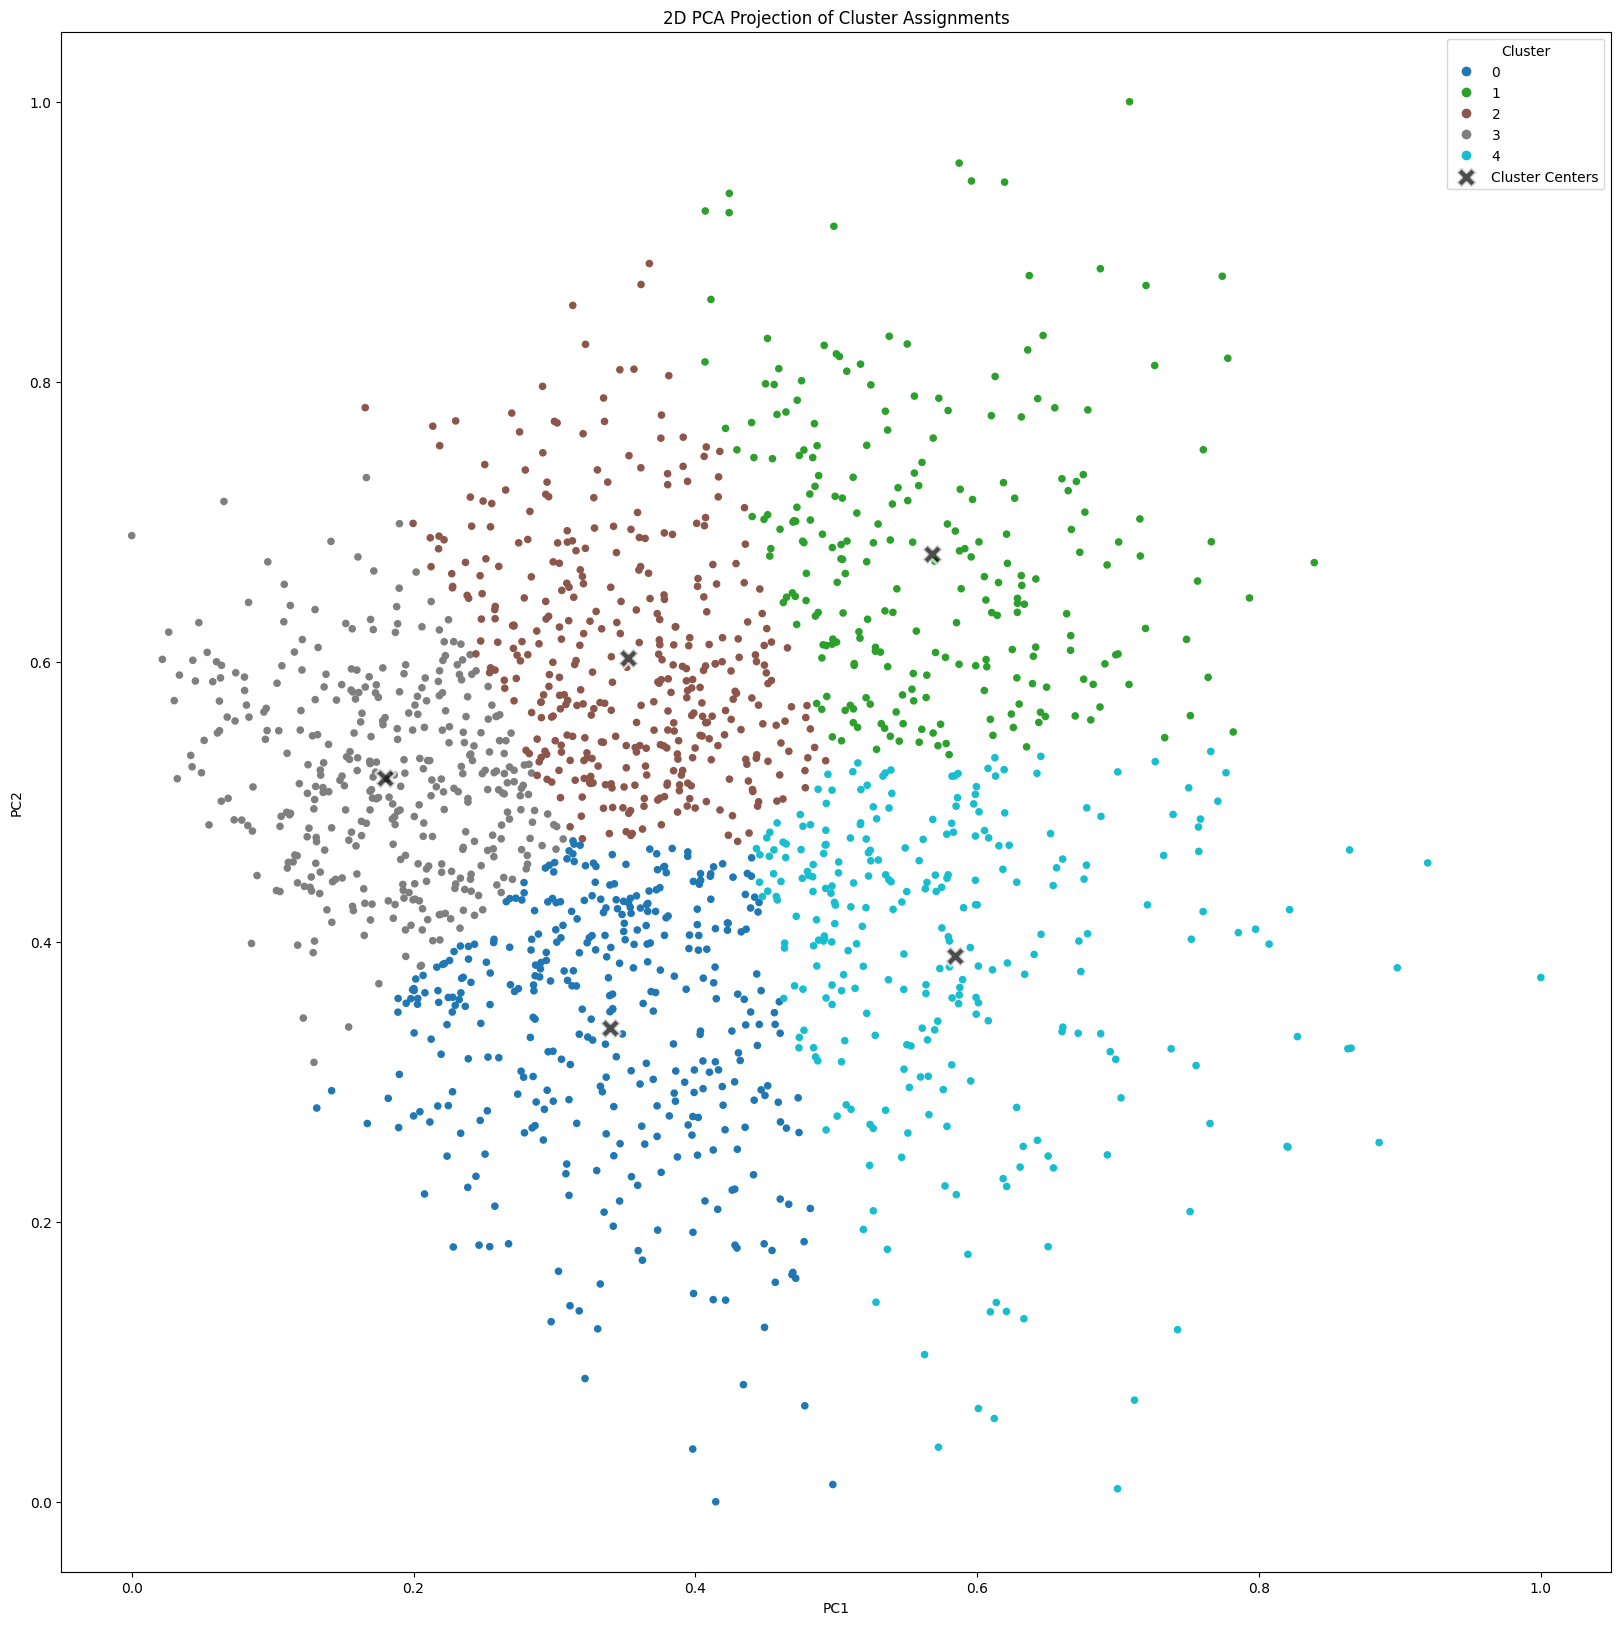

In [84]:
plot_feature_scatter(output, clusters=5, n_components=2)

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


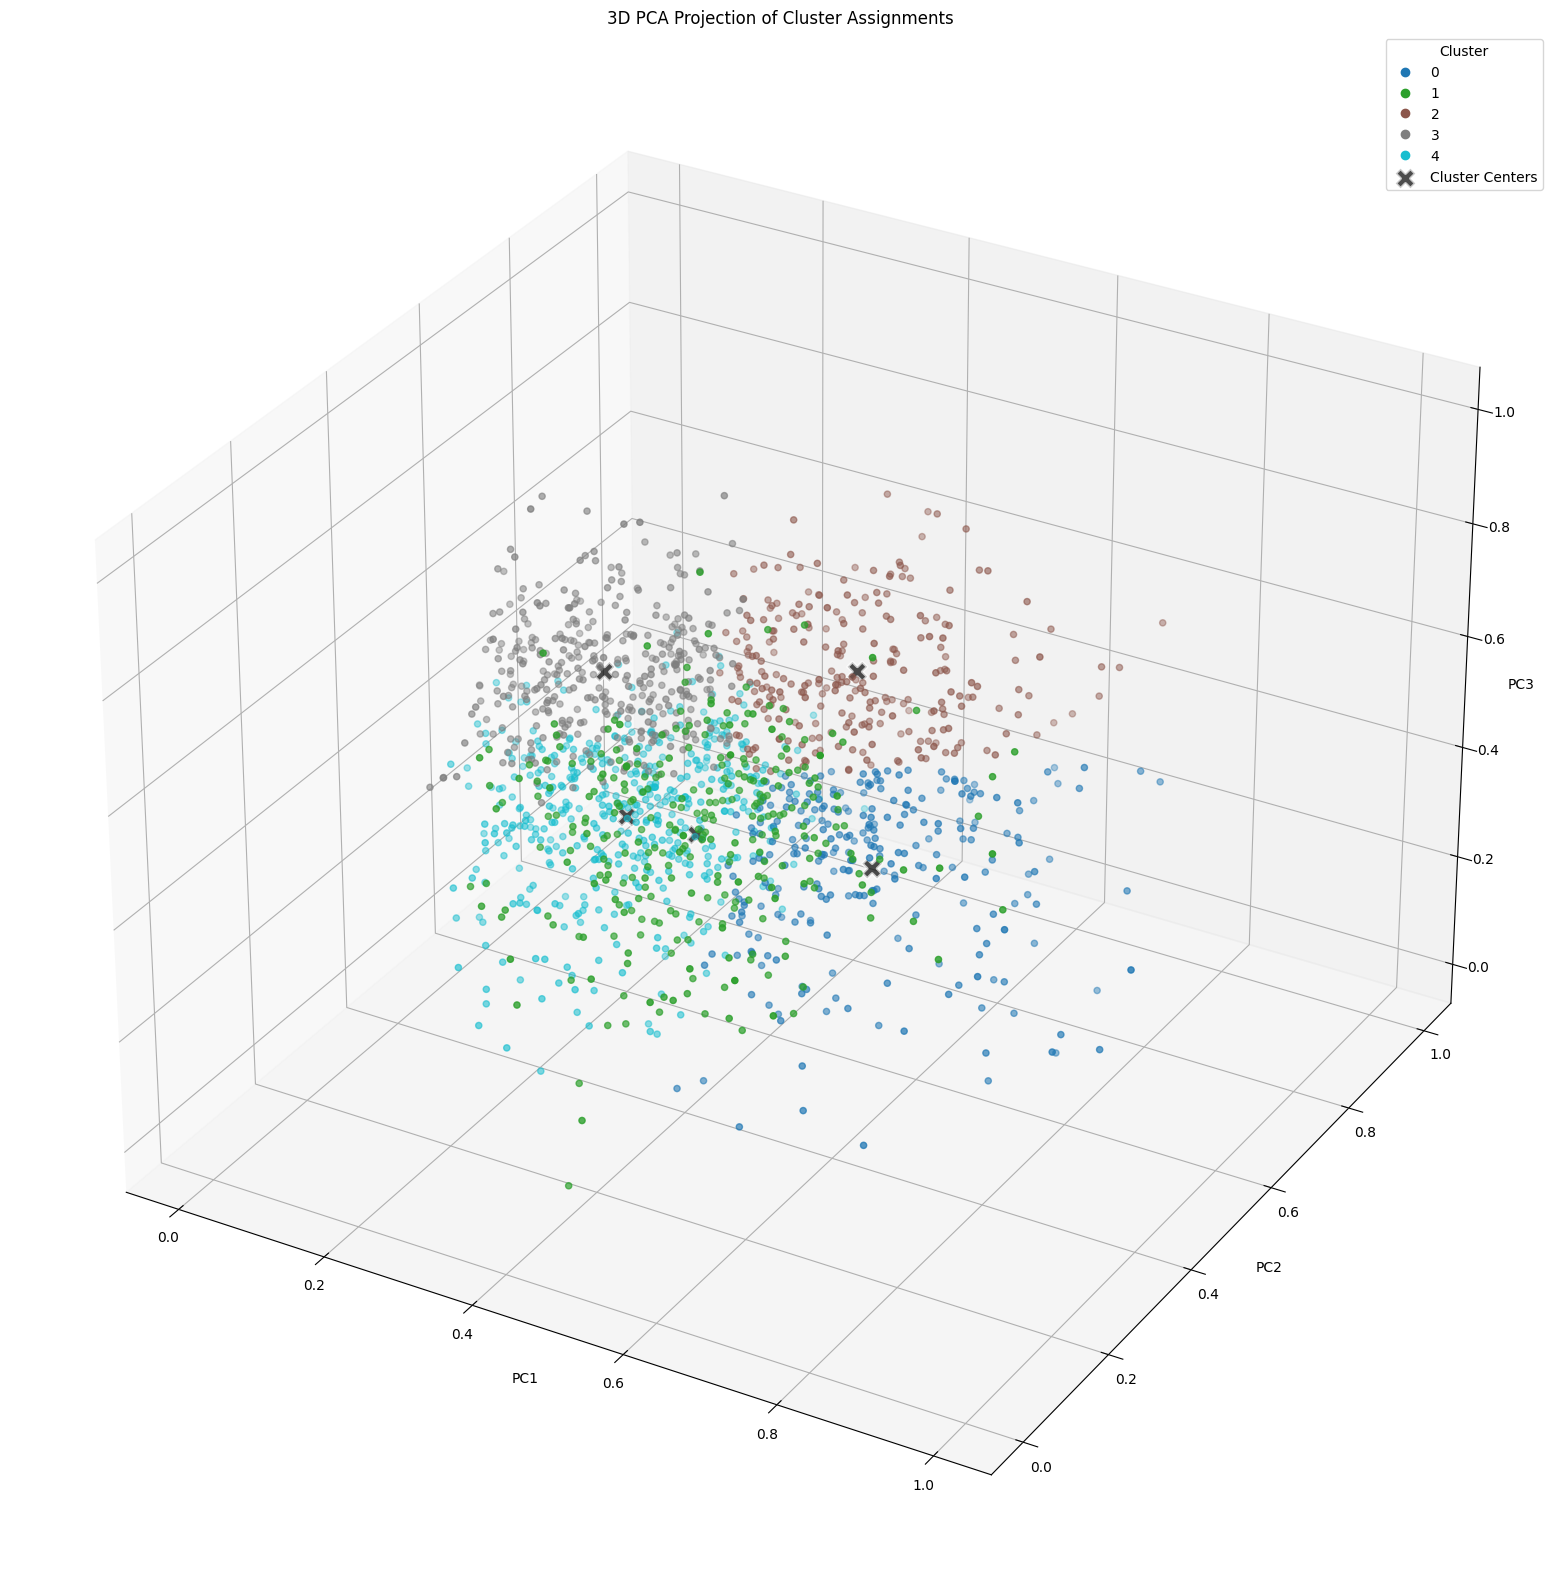

In [85]:
# Plot a 3D scatter plot
plot_feature_scatter(output, clusters=5, n_components=3)